## Fit a model for the relationship between seismic amplitudes and bottom currents

In [8]:
import os
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import datetime

import numpy as np
import obspy
from obspy.clients.fdsn.client import Client 
import obspy

import pandas as pd
import scipy.ndimage
import pwlf


plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams.update({'font.size':14})

# First for HYS14

### Load smoothed seismic amplitudes

In [31]:
# Load seismic time series to make sure we get the timestamps correct
file_name = 'hys14_smoothed_seismic.pickle'
with open(file_name, 'rb') as handle:
    seismic = pickle.load(handle)

### Load bottom currents, smooth, and adjust to correct relationship

In [ ]:
# Load bottom currents and smooth them
with open('hys14_bottomcurrents.pickle', 'rb') as handle:
    currents = pickle.load(handle)
ws_times = currents[0]
# Median currents!!!
ws = currents[2]

# First filter to desired time period
t1 = min(seismic['ztimes'])
t2 = max(seismic['ztimes'])
ws_times = [t for t in ws_times]
ws_keep = [i for i,t in enumerate(ws_times) if ((t>t1) & (t<t2))]
ws = [ws[i] for i in ws_keep]
ws_times = [ws_times[i] for i in ws_keep]


sigma = 8 # hours
sample_rate = 1 # per hour
sigma = sigma * sample_rate
ws=scipy.ndimage.gaussian_filter1d(ws,sigma=sigma)

ws = [c**2 for c in ws]

### Prep data for fitting

In [33]:
seismic_data = seismic['hlow_8sigma_gauss']
seismic_times = seismic['htimes']
seismic_mask = seismic['hlow_mask']

In [34]:
# Apply saved mask to get rid of data outages
seismic_data = np.delete(seismic_data,seismic_mask)
seismic_times = np.delete(seismic_times,seismic_mask)

# Decimate to the same times
hws_times,stimes,hws_filtered,sdata = match_timeseries(ws_times,seismic_times,ws,seismic_data)

xs = np.array(hws_filtered)
ys = np.array(sdata)

### Fit with a single line

In [35]:
def fit_single_line(xs,ys):
    
    # Cycle through slopes

    # Starting slope
    st_slope = (np.max(ys)-np.min(ys))/(np.max(xs)-np.min(xs))
    slope_list = np.linspace(0,st_slope*5,100)

    ribbon_widths = []
    intercepts = []
    for slope in slope_list:
        # Subtract slope from data
        y_new = [y-(xs[i]*slope) for i,y in enumerate(ys)]

        # Sort y values
        sort_ind = np.argsort(y_new)
        y_sorted = [y_new[i] for i in sort_ind]



        N2 = int(len(y_new)/2)
        diffs = []
        for j in range(N2):
            subt = y_sorted[N2 + j] - y_sorted[j]
            diffs.append(subt)

        rib_wid = np.min(diffs)
        rib_ind = np.argmin(diffs)

        inter = np.mean(y_sorted[rib_ind:(N2 + rib_ind)])

        ribbon_widths.append(rib_wid)
        intercepts.append(inter)

    best_ind = np.argmin(ribbon_widths)
    best_slope = slope_list[best_ind]
    best_intercept = intercepts[best_ind]
    best_ribwid = ribbon_widths[best_ind]
    
    return(slope_list,intercepts,best_slope,best_intercept,best_ribwid)

In [36]:
def fit_single_line_fixed_point(xs,ys,fixed_point):
    
    # Cycle through slopes

    # Starting slope
    st_slope = (np.max(ys)-np.min(ys))/(np.max(xs)-np.min(xs))
    slope_list = np.linspace(0,st_slope*5,100)

    ribbon_widths = []
    intercepts = []
    for slope in slope_list:
        
        # Subtract a line that has the slope and goes through the fixed point
        # Using point-slope form of a line here!
        # y = m(x - x1) + y1
        
        y_new = [y-(slope*(xs[i]-fixed_point[0]) + fixed_point[1]) for i,y in enumerate(ys)]

        # Sort y values
        sort_ind = np.argsort(y_new)
        y_sorted = [y_new[i] for i in sort_ind]



        N2 = int(len(y_new)/2)
        diffs = []
        for j in range(N2):
            subt = y_sorted[N2 + j] - y_sorted[j]
            diffs.append(subt)

        rib_wid = np.min(diffs)
        rib_ind = np.argmin(diffs)

        inter = np.mean(y_sorted[rib_ind:(N2 + rib_ind)])

        ribbon_widths.append(rib_wid)
        intercepts.append(inter)

    best_ind = np.argmin(ribbon_widths)
    best_slope = slope_list[best_ind]
    best_intercept = intercepts[best_ind]
    best_ribwid = ribbon_widths[best_ind]
    
    return(slope_list,intercepts,best_slope,best_intercept,best_ribwid)

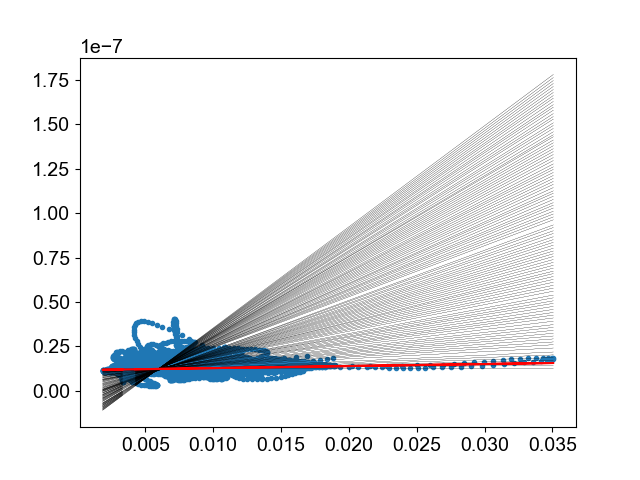

In [37]:
%matplotlib widget

fig,ax = plt.subplots(1)
ax.plot(xs,ys,'.')

slope_list,intercepts,best_slope,best_intercept,best_ribbonwidth = fit_single_line(xs,ys)
# Plot all tested lines
for i,s in enumerate(slope_list):
    line_fit = [x*s + intercepts[i] for x in xs]
    ax.plot(xs,line_fit,'k',linewidth=0.1)
best_line_fit = [x*best_slope + best_intercept for x in xs]
ax.plot(xs,best_line_fit,'r')

# ax.set_ylim([0,0.5e-7])

### Now functionalize this to fit all of the channels

In [38]:
def complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,hinge_list=False,single=False):
    
    # Apply saved mask to get rid of data outages
    seismic_data = np.delete(seismic_data,seismic_mask)
    seismic_times = np.delete(seismic_times,seismic_mask)

    # Decimate to the same times
    hws_times,stimes,hws_filtered,sdata = match_timeseries(ws_times,seismic_times,ws,seismic_data)
    
    xs = np.array(hws_filtered)
    ys = np.array(sdata)
    
    # Remove Nans, if withstanding
    if np.isnan(xs).any():
        nan_ind = [i for i,e in enumerate(xs) if np.isnan(e)]
        xs = np.delete(xs,nan_ind)
        ys = np.delete(ys,nan_ind)
    
    
    # If single=True, solve with a single line
    if single==True:
        slope_list,intercepts,best_slope,best_intercept,best_ribbonwidth = fit_single_line(xs,ys)
        model_fit = [x*best_slope + best_intercept for x in xs]
        return xs,ys,model_fit,best_ribbonwidth

        

    # Otherwise, solve for a line with a hinge
   

    hinge = hinge_list[0]

    median_ribbon = []
    for hinge in hinge_list:

        # Split dataset by hinge
        sort_ind = np.argsort(xs)
        xs_sort = [xs[i] for i in sort_ind]
        ys_sort = [ys[i] for i in sort_ind]
        hinge_ind = np.argmin(np.abs(xs_sort-hinge))
        xs1,ys1 = xs_sort[:hinge_ind],ys_sort[:hinge_ind]
        xs2,ys2 = xs_sort[hinge_ind:],ys_sort[hinge_ind:]
        # Get best fit for the first part of the data
        slope_list,intercepts,best_slope,best_intercept,best_ribwid1 = fit_single_line(xs1,ys1)

        # Get the end point of the first part of the data fit
        # The second part will need to go through this line!
        line_fit1 = [x*best_slope + best_intercept for x in xs1]
        fixed_point = [xs1[-1],line_fit1[-1]]

        # Now solve for second line
        # This is solved differently- pinned to the hinge point
        slope_list,intercepts,best_slope2,best_intercept2,best_ribwid2 = fit_single_line_fixed_point(xs2,ys2,fixed_point)
        # Get second line fit- note that here we use point slope form with the fixed point
        line_fit2 = [x*best_slope2 + best_intercept2 for x in xs2]
        line_fit2 = [best_slope2*(x-fixed_point[0])+fixed_point[1] for x in xs2]
        
        median_ribbon.append(np.max([best_ribwid1,best_ribwid2]))
    
    # Choose hinge that gives smallest median ribbon
    hinge = hinge_list[np.argmin(median_ribbon)]

    # Split dataset by hinge
    sort_ind = np.argsort(xs)
    xs_sort = [xs[i] for i in sort_ind]
    ys_sort = [ys[i] for i in sort_ind]
    hinge_ind = np.argmin(np.abs(xs_sort-hinge))
    xs1,ys1 = xs_sort[:hinge_ind],ys_sort[:hinge_ind]
    xs2,ys2 = xs_sort[hinge_ind:],ys_sort[hinge_ind:]
    # Get best fit for the first part of the data
    slope_list,intercepts,best_slope,best_intercept,best_ribwid1 = fit_single_line(xs1,ys1)

    # Get the end point of the first part of the data fit
    # The second part will need to go through this line!
    line_fit1 = [x*best_slope + best_intercept for x in xs1]
    fixed_point = [xs1[-1],line_fit1[-1]]

    # Now solve for second line
    # This is solved differently- pinned to the hinge point
    slope_list,intercepts,best_slope2,best_intercept2,best_ribwid2 = fit_single_line_fixed_point(xs2,ys2,fixed_point)
    # Get second line fit- note that here we use point slope form with the fixed point
    line_fit2 = [x*best_slope2 + best_intercept2 for x in xs2]
    line_fit2 = [best_slope2*(x-fixed_point[0])+fixed_point[1] for x in xs2]
    
    # Objects to return
    rib_wid = np.min(median_ribbon)
    
    
    return [xs1,xs2],ys,[line_fit1,line_fit2],rib_wid,hinge

### Solve for fits, and plot

Horizontal 3-10
2.909517655217341e-09
Horizontal 25-40
4.137704463033943e-09
Vertical 3-10
1.5088164119207594e-09
Vertical 25-40
5.974434319282074e-09


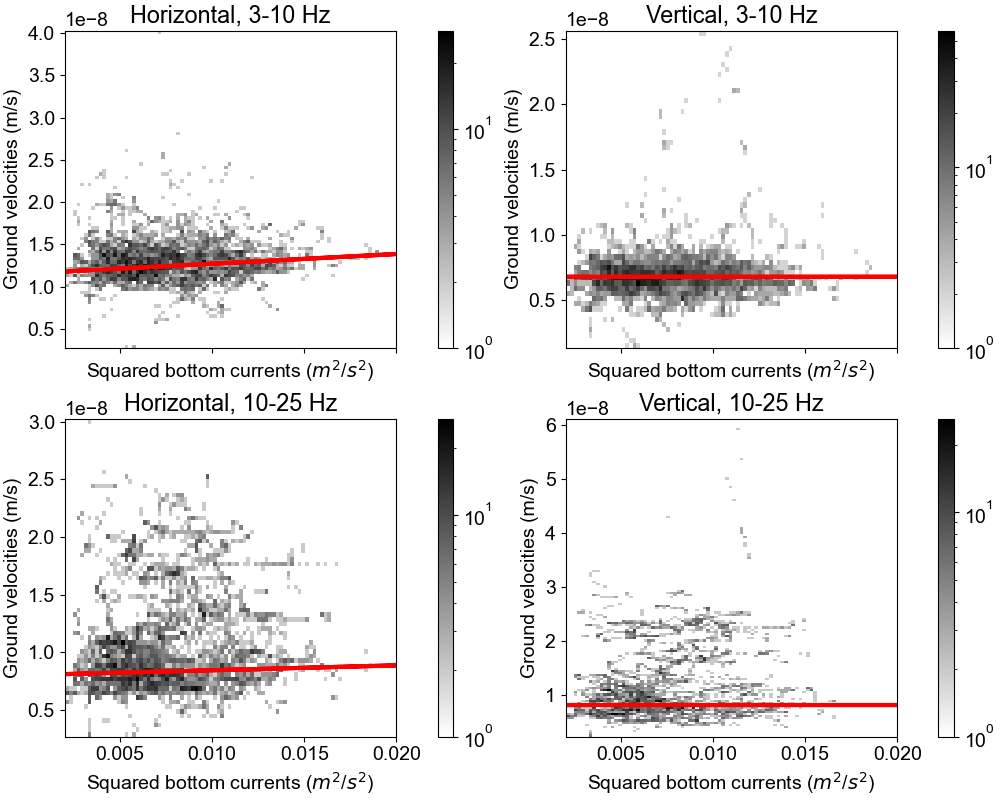

In [39]:
%matplotlib widget

fig,ax = plt.subplots(2,2,figsize=[10,8],sharex=True,layout='constrained')

xbin = 0.0002
ybin = 0.04e-8

# Horizontal low-frequency
seismic_data = seismic['hlow_8sigma_gauss']
seismic_times = seismic['htimes']
seismic_mask = seismic['hlow_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[0,0].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[0,0].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[0,0].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[0,0].set_ylabel('Ground velocities (m/s)')
ax[0,0].set_title('Horizontal, 3-10 Hz')
fig.colorbar(c[3],ax=ax[0,0])
print('Horizontal 3-10')
print(single_ribbon)

# Horizontal high-frequency
seismic_data = seismic['hhigh_8sigma_gauss']
seismic_times = seismic['htimes']
seismic_mask = seismic['hhigh_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[1,0].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[1,0].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[1,0].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[1,0].set_ylabel('Ground velocities (m/s)')
ax[1,0].set_title('Horizontal, 10-25 Hz')
fig.colorbar(c[3],ax=ax[1,0])
print('Horizontal 25-40')
print(single_ribbon)

# Vertical low-frequency
seismic_data = seismic['zlow_8sigma_gauss']
seismic_times = seismic['ztimes']
seismic_mask = seismic['zlow_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[0,1].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[0,1].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[0,1].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[0,1].set_ylabel('Ground velocities (m/s)')
ax[0,1].set_title('Vertical, 3-10 Hz')
fig.colorbar(c[3],ax=ax[0,1])
print('Vertical 3-10')
print(single_ribbon)

# Vertical high-frequency
seismic_data = seismic['zhigh_8sigma_gauss']
seismic_times = seismic['ztimes']
seismic_mask = seismic['zhigh_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[1,1].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[1,1].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[1,1].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[1,1].set_ylabel('Ground velocities (m/s)')
ax[1,1].set_title('Vertical, 10-25 Hz')
fig.colorbar(c[3],ax=ax[1,1])
print('Vertical 25-40')
print(single_ribbon)

ax[0,0].set_xlim([0.002,0.02])


plt.savefig('bottomcurrent_scatters_robust_HYS14.png',dpi=400)

# Now do it all over again, but for HYSB1

In [26]:
# Load seismic time series to make sure we get the timestamps correct
file_name = 'hysb1_smoothed_seismic.pickle'
with open(file_name, 'rb') as handle:
    seismic = pickle.load(handle)

In [27]:
# Load bottom currents and smooth them
with open('/Users/zoekrauss/ooi_tremor/environmental_modeling/hysb1_bottomcurrents.pickle', 'rb') as handle:
    currents = pickle.load(handle)
ws_times = currents[0]
# Median currents!!!
ws = currents[2]

# First filter to desired time period
t1 = min(seismic['ztimes'])
t2 = max(seismic['ztimes'])
ws_times = [t for t in ws_times]
ws_keep = [i for i,t in enumerate(ws_times) if ((t>t1) & (t<t2))]
ws = [ws[i] for i in ws_keep]
ws_times = [ws_times[i] for i in ws_keep]


sigma = 8 # hours
sample_rate = 1 # per hour
sigma = sigma * sample_rate
ws=scipy.ndimage.gaussian_filter1d(ws,sigma=sigma)

ws = [c**2 for c in ws]

Horizontal 3-10
3.759901068384358e-09
Horizontal 25-40
6.600617259230016e-09
Vertical 3-10
2.0858869412735307e-09
Vertical 25-40
3.716485747884932e-09


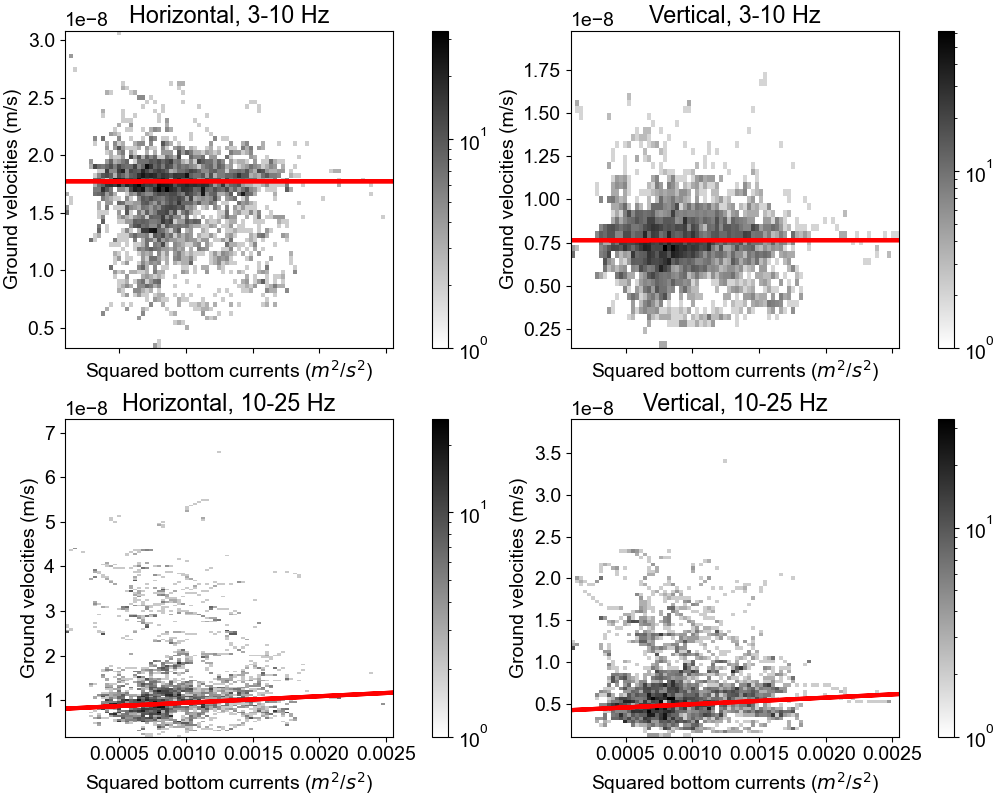

In [28]:
%matplotlib widget

fig,ax = plt.subplots(2,2,figsize=[10,8],sharex=True,layout='constrained')

xbin = 0.00003
ybin = 0.04e-8

# Horizontal low-frequency
seismic_data = seismic['hlow_8sigma_gauss']
seismic_times = seismic['htimes']
seismic_mask = seismic['hlow_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[0,0].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[0,0].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[0,0].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[0,0].set_ylabel('Ground velocities (m/s)')
ax[0,0].set_title('Horizontal, 3-10 Hz')
fig.colorbar(c[3],ax=ax[0,0])
print('Horizontal 3-10')
print(single_ribbon)

# Horizontal high-frequency
seismic_data = seismic['hhigh_8sigma_gauss']
seismic_times = seismic['htimes']
seismic_mask = seismic['hhigh_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[1,0].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[1,0].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[1,0].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[1,0].set_ylabel('Ground velocities (m/s)')
ax[1,0].set_title('Horizontal, 10-25 Hz')
fig.colorbar(c[3],ax=ax[1,0])
print('Horizontal 25-40')
print(single_ribbon)

# Vertical low-frequency
seismic_data = seismic['zlow_8sigma_gauss']
seismic_times = seismic['ztimes']
seismic_mask = seismic['zlow_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[0,1].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[0,1].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[0,1].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[0,1].set_ylabel('Ground velocities (m/s)')
ax[0,1].set_title('Vertical, 3-10 Hz')
fig.colorbar(c[3],ax=ax[0,1])
print('Vertical 3-10')
print(single_ribbon)

# Vertical high-frequency
seismic_data = seismic['zhigh_8sigma_gauss']
seismic_times = seismic['ztimes']
seismic_mask = seismic['zhigh_mask']
xs,ys,model_fit,single_ribbon = complete_model(seismic_data,seismic_times,seismic_mask,ws,ws_times,single=True)
binedges = [np.arange(min(xs),max(xs),xbin),np.arange(min(ys),max(ys),ybin)]
c =ax[1,1].hist2d(xs,ys,binedges,cmap=plt.cm.gray_r,norm=matplotlib.colors.LogNorm());
ax[1,1].plot(xs,model_fit, '-',linewidth=3,color='r')
ax[1,1].set_xlabel('Squared bottom currents ($m^2$/$s^2$)')
ax[1,1].set_ylabel('Ground velocities (m/s)')
ax[1,1].set_title('Vertical, 10-25 Hz')
fig.colorbar(c[3],ax=ax[1,1])
print('Vertical 25-40')
print(single_ribbon)

plt.savefig('bottomcurrent_scatters_robust_HYSB1.png',dpi=400)

## Functions below

In [7]:
def match_timeseries(times1,times2,data1,data2):
    """
    times1 and times2 should be lists of obspy UTCDateTime objects
    
    times1 and data1 should be the same length
    times2 and data2 should be the same length
    
    Returns the same outputs but the lists have been filtered to only include values for the same timestamps
    (All outputs should be the same dimensions)
    """

    # Convert datetime lists to POSIX numbers, easier to process
    list1 = [t.ns for t in times1]
    list2 = [t.ns for t in times2]

    ind_dict = dict((k,i) for i,k in enumerate(list1))
    inter = set(ind_dict).intersection(list2)
    list1_indices = [ ind_dict[x] for x in inter ]
    list1_indices.sort()

    ind_dict = dict((k,i) for i,k in enumerate(list2))
    inter = set(ind_dict).intersection(list1)
    list2_indices = [ ind_dict[x] for x in inter ]
    list2_indices.sort()

    times1_filtered = [times1[i] for i in list1_indices]
    times2_filtered = [times2[i] for i in list2_indices]
    data1_filtered = [data1[i] for i in list1_indices]
    data2_filtered = [data2[i] for i in list2_indices]
    
    return times1_filtered,times2_filtered,data1_filtered,data2_filtered